In [105]:
# import libraries

import torch
import random

import ot
import tensorcircuit as tc
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
import torch
import torch.nn as nn
from torch.linalg import matrix_power
from opt_einsum import contract
from functools import partial
from itertools import combinations
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
from qutip import *

# settings
rc('text', usetex=True)
rc('axes', linewidth=3)
plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['axes.linewidth'] = 1.5
K = tc.set_backend('pytorch')
tc.set_dtype('complex64')

('complex64', 'float32')

# Plotting on the Bloch (Poincare) sphere

In [106]:
def bloch_xyz(inputs):
    # obtain bloch sphere representation vector
    rho = contract('mi,mj->mij', inputs, inputs.conj())
    sigmas = [sigmax().full(), sigmay().full(), sigmaz().full()]
    pos = [np.real(contract('mii->m', contract('mij,jk->mik', rho, x))) for x in sigmas]
    return pos

# The (forward) Diffusion Class

In [107]:
class DiffusionModel(nn.Module):
    def __init__(self, n, T, Ndata):
        '''
        the diffusion quantum circuit model to scramble arbitrary set of states to Haar random states
        Args:
        n: number of qubits
        T: number of diffusion steps
        Ndata: number of samples in the dataset
        '''
        super().__init__()
        self.n = n
        self.T = T
        self.Ndata = Ndata
    
    def HaarSampleGeneration(self, Ndata, seed):
        '''
        generate random haar states,
        used as inputs in the t=T step for backward denoise
        Args:
        Ndata: number of samples in dataset
        '''
        np.random.seed(seed)
        states_T = unitary_group.rvs(dim=2**self.n, size=Ndata)[:,:,0]
        return torch.from_numpy(states_T).cfloat()
    
    def scrambleCircuit_t(self, t, input, phis, gs=None):
        '''
        obtain the state through diffusion step t
        Args:
        t: diffusion step
        input: the input quantum state
        phis: the single-qubit rotation angles in diffusion circuit
        gs: the angle of RZZ gates in diffusion circuit when n>=2
        '''
        c = tc.Circuit(self.n, inputs=input)
        for tt in range(t):
            # single qubit rotations
            for i in range(self.n):
                c.rz(i, theta=phis[3*self.n*tt+i])
                c.ry(i, theta=phis[3*self.n*tt+self.n+i])
                c.rz(i, theta=phis[3*self.n*tt+2*self.n+i])
            # homogenous RZZ on every pair of qubits (n>=2)
            if self.n >= 2:
                for i, j in combinations(range(self.n), 2):
                    c.rzz(i, j, theta=gs[tt]/(2*np.sqrt(self.n)))
        return c.state()
    
    def set_diffusionData_t(self, t, inputs, diff_hs, seed):
        '''
        obtain the quantum data set through diffusion step t
        Args:
        t: diffusion step
        inputs: the input quantum data set
        diff_hs: the hyper-parameter to control the amplitude of quantum circuit angles
        '''
        # set single-qubit rotation angles
        np.random.seed(seed)
        phis = torch.rand(self.Ndata, 3*self.n*t)*np.pi/4. - np.pi/8.
        phis = phis*(diff_hs.repeat(3*self.n))
        if self.n > 1:
            # set homogenous RZZ gate angles
            gs = torch.rand(self.Ndata, t)*0.2 + 0.4
            gs *= diff_hs
        states = torch.zeros((self.Ndata, 2**self.n)).cfloat()
        for i in range(self.Ndata):
            if self.n > 1:
                states[i] = self.scrambleCircuit_t(t, inputs[i], phis[i], gs[i])
            else:
                states[i] = self.scrambleCircuit_t(t, inputs[i], phis[i])
        return states


# One time-step of the PQC in the denoising process (before measurement, parameter dependent)

In [108]:
def backCircuit(input, params, n_tot, L):
    '''
    the backward denoise parameteric quantum circuits,
    designed following the hardware-efficient ansatz
    output is the state before measurmeents on ancillas
    Args:
    input: input quantum state of n_tot qubits
    params: the parameters of the circuit
    n_tot: number of qubits in the circuits
    L: layers of circuit
    '''
    c = tc.Circuit(n_tot, inputs=input)
    for l in range(L):
        for i in range(n_tot):
            c.rx(i, theta=params[2*n_tot*l+i])
            c.ry(i, theta=params[2*n_tot*l+n_tot+i])
        for i in range(n_tot//2):
            c.cz(2*i, 2*i+1)
        for i in range((n_tot-1)//2):
            c.cz(2*i+1, 2*i+2)
    return c.state()


# The reverse QDDPM class

In [109]:
class QDDPM(nn.Module):
    def __init__(self, n, na, T, L):
        '''
        the QDDPM model: backward process only work on cpu
        Args:
        n: number of data qubits
        na: number of ancilla qubits
        T: number of diffusion steps
        L: layers of circuit in each backward step
        '''
        super().__init__()
        self.n = n
        self.na = na
        self.n_tot = n + na
        self.T = T
        self.L = L
        # embed the circuit to a vectorized pytorch neural network layer
        self.backCircuit_vmap = K.vmap(partial(backCircuit, n_tot=self.n_tot, L=L), vectorized_argnums=0)

    def set_diffusionSet(self, states_diff):
        self.states_diff = torch.from_numpy(states_diff).cfloat()

    def randomMeasure(self, inputs):
        '''
        Given the inputs on both data & ancilla qubits before measurmenets,
        calculate the post-measurement state.
        The measurement and state output are calculated in parallel for data samples
        Args:
        inputs: states to be measured, first na qubit is ancilla
        '''
        m_probs = (torch.abs(inputs.reshape(inputs.shape[0], 2**self.na, 2**self.n))**2).sum(dim=2)
        m_res = torch.multinomial(m_probs, num_samples=1).squeeze() # measurment results
        indices = 2**self.n * m_res.view(-1, 1) + torch.arange(2**self.n)
        post_state = torch.gather(inputs, 1, indices)
        norms = torch.sqrt(torch.sum(torch.abs(post_state)**2, axis=1)).unsqueeze(dim=1)
        return 1./norms * post_state

    def backwardOutput_t(self, inputs, params):
        '''
        Backward denoise process at step t
        Args:
        inputs: the input data set at step t
        '''
        # outputs through quantum circuits before measurement
        output_full = self.backCircuit_vmap(inputs, params) 
        # perform measurement
        output_t = self.randomMeasure(output_full)
        return output_t
    
    def prepareInput_t(self, inputs_T, params_tot, t, Ndata):
        '''
        prepare the input samples for step t
        Args:
        inputs_T: the input state at the beginning of backward
        params_tot: all circuit parameters till step t+1
        '''
        self.input_tplus1 = torch.zeros((Ndata, 2**self.n_tot)).cfloat()
        self.input_tplus1[:,:2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, t, -1):
                self.input_tplus1[:,:2**self.n] = self.backwardOutput_t(self.input_tplus1, params_tot[tt])
        return self.input_tplus1
    
    def backDataGeneration(self, inputs_T, params_tot, Ndata):
        '''
        generate the dataset in backward denoise process with training data set
        '''
        states = torch.zeros((self.T+1, Ndata, 2**self.n_tot)).cfloat()
        states[-1, :, :2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, -1, -1):
                states[tt, :, :2**self.n] = self.backwardOutput_t(states[tt+1], params_tot[tt])
        return states


# Various distance measures

In [110]:
def naturalDistance(Set1, Set2):
    '''
        a natural measure on the distance between two sets of quantum states
        definition: 2*d - r1-r2
        d: mean of inter-distance between Set1 and Set2
        r1/r2: mean of intra-distance within Set1/Set2
    '''
    # a natural measure on the distance between two sets, according to trace distance
    r11 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set1))**2)
    r22 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set2.conj(), Set2))**2)
    r12 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set2))**2)
    return 2*r12 - r11 - r22


def WassDistance(Set1, Set2):
    '''
        calculate the Wasserstein distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
    '''
    D = 1. - torch.abs(Set1.conj() @ Set2.T)**2.
    emt = torch.empty(0)
    Wass_dis = ot.emd2(emt, emt, M=D)
    return Wass_dis


def sinkhornDistance(Set1, Set2, reg=0.005, log=False):
    '''
        calculate the Sinkhorn distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
        reg: the regularization coefficient
        log: whether to use the log-solver
    '''
    D = 1. - torch.abs(Set1.conj() @  Set2.T)**2.
    emt = torch.empty(0)
    if log == True:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg, method='sinkhorn_log')
    else:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg)
    return sh_dis


## Generate the clustered data set (clustered around $\ket{0}$ and $\ket{1}$)

In [112]:
def cluster0Gen(n, N_train, scale, seed=None):
    '''
    generate random quantum states close to |0...0>
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes except |0...0>
    seed: control the randomness
    '''
    np.random.seed(seed)
    # amplitude for basis except |0...0>
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
    states = np.hstack((np.ones((N_train,1)), scale*remains)) # un-normalized
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(np.complex64)

def cluster1Gen(n, N_train, scale, seed=None):
    '''
    generate random quantum states close to |1...1>
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes except |1...1>
    seed: control the randomness
    '''
    np.random.seed(seed)
    # amplitude for basis except |1>
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
    states = np.hstack((scale*remains, np.ones((N_train,1)))) # un-normalized
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(np.complex64)


def MultiModeData(n,N_train,scale,seed=None):
    '''
    generate random quantum states in a multimodal state
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes  
    seed: control the randomness
    '''

    np.random.seed(seed)
    D0 = cluster0Gen(n, N_train, scale, seed=None)
    D1 = cluster1Gen(n, N_train, scale, seed=None)
    D3 = [] 
    for i in range(N_train):
        D3.append(np.kron([1,0],D0[i]))
        D3.append(np.kron([0,1],D1[i]))
    D3 = np.array(D3, dtype=complex)
    return D3

## Fidelity computation

In [113]:
def compute_fidelity(Xout):
    '''
    Given Xout of shape [T+1, Ndata, 2**n], compute the fidelity between times t = t and t = 0 as a function of T averaged over the batch 
    '''
    arr = np.zeros(T)
    for i in range(T):
        arr[i] = np.sum([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) / Ndata
    return arr


## Generate diffusion dataset

In [24]:
# generate dfifusion data set
n = 2 # single qubit dataset 
T = 20 # number of time-steps in the diffusion and denoising process
Ndata = 200 #number of training data

diff_hs = np.linspace(1., 4., T) # diffusion hyperparameters
diff_hs = torch.from_numpy(diff_hs)

model_diff = DiffusionModel(n, T, Ndata) # define the model

DataSet = MultiModeData(n=1,N_train=int(Ndata/2),scale=0.05,seed=None)

X = torch.from_numpy(DataSet)

Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()

for t in tqdm(range(1, T+1)):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()



100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


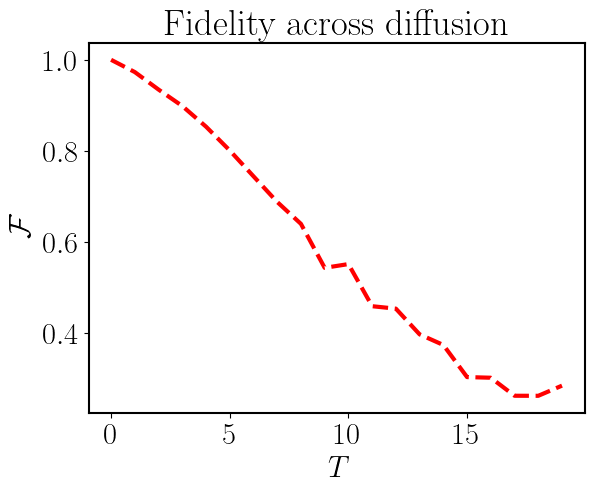

In [115]:
# visualize the decay of the fidelity as the diffusion proceeds

arr = compute_fidelity(Xout)
plt.plot(arr,"--r",linewidth=3)
plt.xlabel(r'$T$')
plt.ylabel(r'$\mathcal{F}$')
plt.title('Fidelity across diffusion')
plt.savefig('multimodal_fidelity_.pdf',bbox_inches='tight')

/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  u = np.random.choice([0,1], p=[p0,p1])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:24: RuntimeWarning: invalid value encountered in divide
  state_red = state_red / np.linalg.norm(state_red)
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:20: RuntimeWarning: invalid value encountered in divide
  state_red = state_red / np.linalg.norm(state_red)


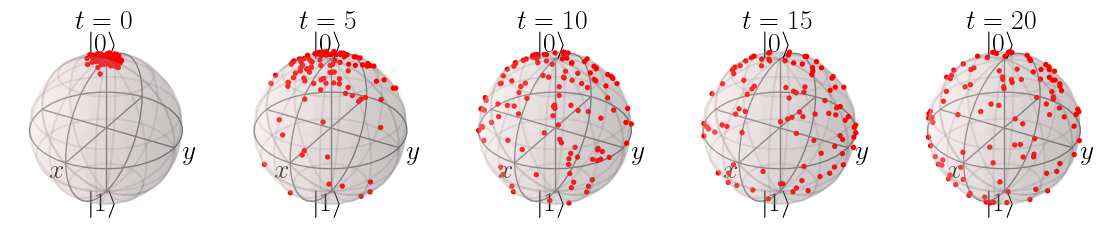

In [144]:
X_train = np.array(states_train,dtype=complex)
X_train_0, X_train_1 = project_ancilla(Xout)
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(np.array(X_train_0[i]))
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*(len(X_train_0[i]))
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1

plt.savefig('multimodal_bloch_curves_DIFFUSION_ZERO.pdf',bbox_inches='tight')


/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  u = np.random.choice([0,1], p=[p0,p1])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:24: RuntimeWarning: invalid value encountered in divide
  state_red = state_red / np.linalg.norm(state_red)


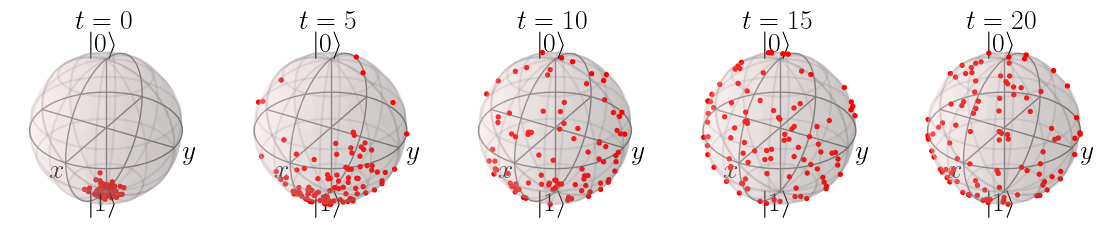

In [145]:
X_train = np.array(states_train,dtype=complex)
X_train_0, X_train_1 = project_ancilla(Xout)
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(np.array(X_train_1[i]))
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*(len(X_train_1[i]))
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1

plt.savefig('multimodal_bloch_curves_DIFFUSION_ONE.pdf',bbox_inches='tight')


In [ ]:
X_train = np.array(states_train,dtype=complex)
X_train_0, X_train_1 = project_ancilla(Xout)
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(np.array(X_train_0[i]))
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['g']*(len(X_train_0[i]))
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1

plt.savefig('multimodal_bloch_curves_DIFFUSION_ZERO.pdf',bbox_inches='tight')


## Main training function for the model

In [116]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [119]:
# denoise training

na = 1 # number of ancilla qubits
L = 4 # layer of backward PQC
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = Xout
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)
params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T,epochs))

for t in tqdm(range(T-1, -1, -1)):
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs) #train the PQC at t, store the results in params_tot, and then 
    params_tot[t] = (params).detach().numpy()                                     # train at t - 1, and so on
    loss_tot[t] = (loss_hist).detach().numpy() 

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0, loss: tensor(0.0512, grad_fn=<SubBackward0>), time elapsed: 0.017161130905151367 seconds
Step 100, loss: tensor(0.0376, grad_fn=<SubBackward0>), time elapsed: 1.2012829780578613 seconds
Step 200, loss: tensor(0.0229, grad_fn=<SubBackward0>), time elapsed: 2.483781099319458 seconds
Step 300, loss: tensor(0.0162, grad_fn=<SubBackward0>), time elapsed: 3.723083019256592 seconds
Step 400, loss: tensor(0.0103, grad_fn=<SubBackward0>), time elapsed: 5.015811920166016 seconds
Step 500, loss: tensor(0.0081, grad_fn=<SubBackward0>), time elapsed: 6.3145740032196045 seconds
Step 600, loss: tensor(0.0063, grad_fn=<SubBackward0>), time elapsed: 7.593577146530151 seconds
Step 700, loss: tensor(0.0042, grad_fn=<SubBackward0>), time elapsed: 8.816402196884155 seconds
Step 800, loss: tensor(0.0033, grad_fn=<SubBackward0>), time elapsed: 10.136698961257935 seconds
Step 900, loss: tensor(0.0050, grad_fn=<SubBackward0>), time elapsed: 11.437366962432861 seconds
Step 1000, loss: tensor(0.0044, gra

  5%|▌         | 1/20 [00:26<08:14, 26.01s/it]

Step 0, loss: tensor(0.1034, grad_fn=<SubBackward0>), time elapsed: 0.014002084732055664 seconds
Step 100, loss: tensor(0.0648, grad_fn=<SubBackward0>), time elapsed: 1.2165372371673584 seconds
Step 200, loss: tensor(0.0328, grad_fn=<SubBackward0>), time elapsed: 2.9944450855255127 seconds
Step 300, loss: tensor(0.0303, grad_fn=<SubBackward0>), time elapsed: 4.311551094055176 seconds
Step 400, loss: tensor(0.0159, grad_fn=<SubBackward0>), time elapsed: 5.571672201156616 seconds
Step 500, loss: tensor(0.0102, grad_fn=<SubBackward0>), time elapsed: 6.88733696937561 seconds
Step 600, loss: tensor(0.0080, grad_fn=<SubBackward0>), time elapsed: 8.120447158813477 seconds
Step 700, loss: tensor(0.0045, grad_fn=<SubBackward0>), time elapsed: 9.419611930847168 seconds
Step 800, loss: tensor(0.0049, grad_fn=<SubBackward0>), time elapsed: 10.666421175003052 seconds
Step 900, loss: tensor(0.0040, grad_fn=<SubBackward0>), time elapsed: 11.988282918930054 seconds
Step 1000, loss: tensor(0.0041, grad

 10%|█         | 2/20 [00:53<07:59, 26.65s/it]

Step 0, loss: tensor(0.0960, grad_fn=<SubBackward0>), time elapsed: 0.012598037719726562 seconds
Step 100, loss: tensor(0.0788, grad_fn=<SubBackward0>), time elapsed: 1.3208630084991455 seconds
Step 200, loss: tensor(0.0577, grad_fn=<SubBackward0>), time elapsed: 2.5897653102874756 seconds
Step 300, loss: tensor(0.0337, grad_fn=<SubBackward0>), time elapsed: 4.305464267730713 seconds
Step 400, loss: tensor(0.0238, grad_fn=<SubBackward0>), time elapsed: 5.655158042907715 seconds
Step 500, loss: tensor(0.0147, grad_fn=<SubBackward0>), time elapsed: 7.019428253173828 seconds
Step 600, loss: tensor(0.0090, grad_fn=<SubBackward0>), time elapsed: 8.277199268341064 seconds
Step 700, loss: tensor(0.0080, grad_fn=<SubBackward0>), time elapsed: 9.566524267196655 seconds
Step 800, loss: tensor(0.0050, grad_fn=<SubBackward0>), time elapsed: 10.808570146560669 seconds
Step 900, loss: tensor(0.0050, grad_fn=<SubBackward0>), time elapsed: 11.967985153198242 seconds
Step 1000, loss: tensor(0.0104, gra

 15%|█▌        | 3/20 [01:20<07:35, 26.78s/it]

Step 0, loss: tensor(0.0543, grad_fn=<SubBackward0>), time elapsed: 0.014611005783081055 seconds
Step 100, loss: tensor(0.0297, grad_fn=<SubBackward0>), time elapsed: 1.3077356815338135 seconds
Step 200, loss: tensor(0.0188, grad_fn=<SubBackward0>), time elapsed: 2.5760788917541504 seconds
Step 300, loss: tensor(0.0202, grad_fn=<SubBackward0>), time elapsed: 3.8203928470611572 seconds
Step 400, loss: tensor(0.0108, grad_fn=<SubBackward0>), time elapsed: 5.133926868438721 seconds
Step 500, loss: tensor(0.0068, grad_fn=<SubBackward0>), time elapsed: 6.377311944961548 seconds
Step 600, loss: tensor(0.0123, grad_fn=<SubBackward0>), time elapsed: 7.670177698135376 seconds
Step 700, loss: tensor(0.0054, grad_fn=<SubBackward0>), time elapsed: 9.333629846572876 seconds
Step 800, loss: tensor(0.0056, grad_fn=<SubBackward0>), time elapsed: 12.064657926559448 seconds
Step 900, loss: tensor(0.0043, grad_fn=<SubBackward0>), time elapsed: 13.444730758666992 seconds
Step 1000, loss: tensor(0.0030, gr

 20%|██        | 4/20 [01:48<07:21, 27.61s/it]

Step 0, loss: tensor(0.0375, grad_fn=<SubBackward0>), time elapsed: 0.0237429141998291 seconds
Step 100, loss: tensor(0.0123, grad_fn=<SubBackward0>), time elapsed: 1.3022840023040771 seconds
Step 200, loss: tensor(0.0106, grad_fn=<SubBackward0>), time elapsed: 2.628664970397949 seconds
Step 300, loss: tensor(0.0060, grad_fn=<SubBackward0>), time elapsed: 3.987252950668335 seconds
Step 400, loss: tensor(0.0061, grad_fn=<SubBackward0>), time elapsed: 5.2250049114227295 seconds
Step 500, loss: tensor(0.0048, grad_fn=<SubBackward0>), time elapsed: 6.439487934112549 seconds
Step 600, loss: tensor(0.0037, grad_fn=<SubBackward0>), time elapsed: 7.739804983139038 seconds
Step 700, loss: tensor(0.0064, grad_fn=<SubBackward0>), time elapsed: 8.935546159744263 seconds
Step 800, loss: tensor(0.0021, grad_fn=<SubBackward0>), time elapsed: 10.16565990447998 seconds
Step 900, loss: tensor(0.0014, grad_fn=<SubBackward0>), time elapsed: 11.41619873046875 seconds
Step 1000, loss: tensor(0.0047, grad_fn

 25%|██▌       | 5/20 [02:16<06:51, 27.43s/it]

Step 0, loss: tensor(0.1275, grad_fn=<SubBackward0>), time elapsed: 0.014812231063842773 seconds
Step 100, loss: tensor(0.0925, grad_fn=<SubBackward0>), time elapsed: 1.219580888748169 seconds
Step 200, loss: tensor(0.0653, grad_fn=<SubBackward0>), time elapsed: 2.5722391605377197 seconds
Step 300, loss: tensor(0.0457, grad_fn=<SubBackward0>), time elapsed: 3.833627223968506 seconds
Step 400, loss: tensor(0.0369, grad_fn=<SubBackward0>), time elapsed: 5.160866022109985 seconds
Step 500, loss: tensor(0.0235, grad_fn=<SubBackward0>), time elapsed: 6.440721273422241 seconds
Step 600, loss: tensor(0.0234, grad_fn=<SubBackward0>), time elapsed: 7.8031251430511475 seconds
Step 700, loss: tensor(0.0170, grad_fn=<SubBackward0>), time elapsed: 9.700786352157593 seconds
Step 800, loss: tensor(0.0122, grad_fn=<SubBackward0>), time elapsed: 11.019454002380371 seconds
Step 900, loss: tensor(0.0115, grad_fn=<SubBackward0>), time elapsed: 12.268785238265991 seconds
Step 1000, loss: tensor(0.0077, gra

 30%|███       | 6/20 [02:43<06:23, 27.42s/it]

Step 0, loss: tensor(0.0508, grad_fn=<SubBackward0>), time elapsed: 0.013381242752075195 seconds
Step 100, loss: tensor(0.0307, grad_fn=<SubBackward0>), time elapsed: 1.3480372428894043 seconds
Step 200, loss: tensor(0.0204, grad_fn=<SubBackward0>), time elapsed: 2.4968791007995605 seconds
Step 300, loss: tensor(0.0107, grad_fn=<SubBackward0>), time elapsed: 3.6412689685821533 seconds
Step 400, loss: tensor(0.0109, grad_fn=<SubBackward0>), time elapsed: 4.812779188156128 seconds
Step 500, loss: tensor(0.0066, grad_fn=<SubBackward0>), time elapsed: 5.941812992095947 seconds
Step 600, loss: tensor(0.0070, grad_fn=<SubBackward0>), time elapsed: 7.067771911621094 seconds
Step 700, loss: tensor(0.0091, grad_fn=<SubBackward0>), time elapsed: 8.24927806854248 seconds
Step 800, loss: tensor(0.0036, grad_fn=<SubBackward0>), time elapsed: 9.39588212966919 seconds
Step 900, loss: tensor(0.0067, grad_fn=<SubBackward0>), time elapsed: 10.578502178192139 seconds
Step 1000, loss: tensor(0.0028, grad_

 35%|███▌      | 7/20 [03:08<05:45, 26.55s/it]

Step 0, loss: tensor(0.0780, grad_fn=<SubBackward0>), time elapsed: 0.013441085815429688 seconds
Step 100, loss: tensor(0.0549, grad_fn=<SubBackward0>), time elapsed: 1.3640611171722412 seconds
Step 200, loss: tensor(0.0359, grad_fn=<SubBackward0>), time elapsed: 2.6223390102386475 seconds
Step 300, loss: tensor(0.0262, grad_fn=<SubBackward0>), time elapsed: 4.263401985168457 seconds
Step 400, loss: tensor(0.0259, grad_fn=<SubBackward0>), time elapsed: 5.481034994125366 seconds
Step 500, loss: tensor(0.0162, grad_fn=<SubBackward0>), time elapsed: 7.078701019287109 seconds
Step 600, loss: tensor(0.0202, grad_fn=<SubBackward0>), time elapsed: 8.657435178756714 seconds
Step 700, loss: tensor(0.0186, grad_fn=<SubBackward0>), time elapsed: 10.307857036590576 seconds
Step 800, loss: tensor(0.0132, grad_fn=<SubBackward0>), time elapsed: 11.884701251983643 seconds
Step 900, loss: tensor(0.0136, grad_fn=<SubBackward0>), time elapsed: 13.341896057128906 seconds
Step 1000, loss: tensor(0.0165, gr

 40%|████      | 8/20 [03:38<05:31, 27.64s/it]

Step 0, loss: tensor(0.0408, grad_fn=<SubBackward0>), time elapsed: 0.016343116760253906 seconds
Step 100, loss: tensor(0.0353, grad_fn=<SubBackward0>), time elapsed: 1.299959659576416 seconds
Step 200, loss: tensor(0.0224, grad_fn=<SubBackward0>), time elapsed: 2.510197877883911 seconds
Step 300, loss: tensor(0.0242, grad_fn=<SubBackward0>), time elapsed: 3.7476449012756348 seconds
Step 400, loss: tensor(0.0134, grad_fn=<SubBackward0>), time elapsed: 4.947669982910156 seconds
Step 500, loss: tensor(0.0095, grad_fn=<SubBackward0>), time elapsed: 6.152261972427368 seconds
Step 600, loss: tensor(0.0061, grad_fn=<SubBackward0>), time elapsed: 7.346977949142456 seconds
Step 700, loss: tensor(0.0059, grad_fn=<SubBackward0>), time elapsed: 9.030670881271362 seconds
Step 800, loss: tensor(0.0049, grad_fn=<SubBackward0>), time elapsed: 10.21527886390686 seconds
Step 900, loss: tensor(0.0069, grad_fn=<SubBackward0>), time elapsed: 11.524934768676758 seconds
Step 1000, loss: tensor(0.0029, grad_

 45%|████▌     | 9/20 [04:05<05:02, 27.49s/it]

Step 0, loss: tensor(0.0188, grad_fn=<SubBackward0>), time elapsed: 0.018382787704467773 seconds
Step 100, loss: tensor(0.0162, grad_fn=<SubBackward0>), time elapsed: 1.302603006362915 seconds
Step 200, loss: tensor(0.0162, grad_fn=<SubBackward0>), time elapsed: 2.702396869659424 seconds
Step 300, loss: tensor(0.0190, grad_fn=<SubBackward0>), time elapsed: 4.102568864822388 seconds
Step 400, loss: tensor(0.0093, grad_fn=<SubBackward0>), time elapsed: 5.41915488243103 seconds
Step 500, loss: tensor(0.0095, grad_fn=<SubBackward0>), time elapsed: 6.9962239265441895 seconds
Step 600, loss: tensor(0.0075, grad_fn=<SubBackward0>), time elapsed: 8.728435754776001 seconds
Step 700, loss: tensor(0.0100, grad_fn=<SubBackward0>), time elapsed: 10.12700080871582 seconds
Step 800, loss: tensor(0.0083, grad_fn=<SubBackward0>), time elapsed: 11.400797843933105 seconds
Step 900, loss: tensor(0.0063, grad_fn=<SubBackward0>), time elapsed: 12.997798919677734 seconds
Step 1000, loss: tensor(0.0032, grad_

 50%|█████     | 10/20 [04:32<04:35, 27.51s/it]

Step 0, loss: tensor(0.1017, grad_fn=<SubBackward0>), time elapsed: 0.014163970947265625 seconds
Step 100, loss: tensor(0.0751, grad_fn=<SubBackward0>), time elapsed: 1.7417988777160645 seconds
Step 200, loss: tensor(0.0537, grad_fn=<SubBackward0>), time elapsed: 2.9510347843170166 seconds
Step 300, loss: tensor(0.0377, grad_fn=<SubBackward0>), time elapsed: 4.146059989929199 seconds
Step 400, loss: tensor(0.0282, grad_fn=<SubBackward0>), time elapsed: 5.320168972015381 seconds
Step 500, loss: tensor(0.0216, grad_fn=<SubBackward0>), time elapsed: 6.4551708698272705 seconds
Step 600, loss: tensor(0.0174, grad_fn=<SubBackward0>), time elapsed: 7.650329113006592 seconds
Step 700, loss: tensor(0.0129, grad_fn=<SubBackward0>), time elapsed: 8.841588973999023 seconds
Step 800, loss: tensor(0.0101, grad_fn=<SubBackward0>), time elapsed: 10.053109884262085 seconds
Step 900, loss: tensor(0.0116, grad_fn=<SubBackward0>), time elapsed: 11.254440784454346 seconds
Step 1000, loss: tensor(0.0083, gr

 55%|█████▌    | 11/20 [05:00<04:07, 27.51s/it]

Step 0, loss: tensor(0.0912, grad_fn=<SubBackward0>), time elapsed: 0.054531097412109375 seconds
Step 100, loss: tensor(0.0715, grad_fn=<SubBackward0>), time elapsed: 1.4444432258605957 seconds
Step 200, loss: tensor(0.0513, grad_fn=<SubBackward0>), time elapsed: 2.766395092010498 seconds
Step 300, loss: tensor(0.0426, grad_fn=<SubBackward0>), time elapsed: 4.055689096450806 seconds
Step 400, loss: tensor(0.0325, grad_fn=<SubBackward0>), time elapsed: 5.28393816947937 seconds
Step 500, loss: tensor(0.0224, grad_fn=<SubBackward0>), time elapsed: 6.436892986297607 seconds
Step 600, loss: tensor(0.0255, grad_fn=<SubBackward0>), time elapsed: 7.604603290557861 seconds
Step 700, loss: tensor(0.0179, grad_fn=<SubBackward0>), time elapsed: 8.793988227844238 seconds
Step 800, loss: tensor(0.0140, grad_fn=<SubBackward0>), time elapsed: 9.95198106765747 seconds
Step 900, loss: tensor(0.0137, grad_fn=<SubBackward0>), time elapsed: 11.105660915374756 seconds
Step 1000, loss: tensor(0.0096, grad_fn

 60%|██████    | 12/20 [05:26<03:35, 27.00s/it]

Step 0, loss: tensor(0.0606, grad_fn=<SubBackward0>), time elapsed: 0.017517805099487305 seconds
Step 100, loss: tensor(0.0341, grad_fn=<SubBackward0>), time elapsed: 1.517582893371582 seconds
Step 200, loss: tensor(0.0192, grad_fn=<SubBackward0>), time elapsed: 3.0512568950653076 seconds
Step 300, loss: tensor(0.0130, grad_fn=<SubBackward0>), time elapsed: 4.384527921676636 seconds
Step 400, loss: tensor(0.0111, grad_fn=<SubBackward0>), time elapsed: 5.7369139194488525 seconds
Step 500, loss: tensor(0.0097, grad_fn=<SubBackward0>), time elapsed: 7.1674299240112305 seconds
Step 600, loss: tensor(0.0062, grad_fn=<SubBackward0>), time elapsed: 8.707746982574463 seconds
Step 700, loss: tensor(0.0038, grad_fn=<SubBackward0>), time elapsed: 10.18237590789795 seconds
Step 800, loss: tensor(0.0033, grad_fn=<SubBackward0>), time elapsed: 12.034165143966675 seconds
Step 900, loss: tensor(0.0032, grad_fn=<SubBackward0>), time elapsed: 13.215574026107788 seconds
Step 1000, loss: tensor(0.0023, gr

 65%|██████▌   | 13/20 [05:55<03:13, 27.59s/it]

Step 0, loss: tensor(0.0773, grad_fn=<SubBackward0>), time elapsed: 0.012269020080566406 seconds
Step 100, loss: tensor(0.0528, grad_fn=<SubBackward0>), time elapsed: 1.4457159042358398 seconds
Step 200, loss: tensor(0.0454, grad_fn=<SubBackward0>), time elapsed: 2.6635279655456543 seconds
Step 300, loss: tensor(0.0322, grad_fn=<SubBackward0>), time elapsed: 3.8675098419189453 seconds
Step 400, loss: tensor(0.0299, grad_fn=<SubBackward0>), time elapsed: 5.070006847381592 seconds
Step 500, loss: tensor(0.0209, grad_fn=<SubBackward0>), time elapsed: 6.24101996421814 seconds
Step 600, loss: tensor(0.0160, grad_fn=<SubBackward0>), time elapsed: 7.4224560260772705 seconds
Step 700, loss: tensor(0.0139, grad_fn=<SubBackward0>), time elapsed: 8.608824014663696 seconds
Step 800, loss: tensor(0.0105, grad_fn=<SubBackward0>), time elapsed: 9.82917594909668 seconds
Step 900, loss: tensor(0.0074, grad_fn=<SubBackward0>), time elapsed: 11.146974086761475 seconds
Step 1000, loss: tensor(0.0078, grad

 70%|███████   | 14/20 [06:21<02:43, 27.23s/it]

Step 0, loss: tensor(0.1488, grad_fn=<SubBackward0>), time elapsed: 0.014026403427124023 seconds
Step 100, loss: tensor(0.1244, grad_fn=<SubBackward0>), time elapsed: 1.259568214416504 seconds
Step 200, loss: tensor(0.0854, grad_fn=<SubBackward0>), time elapsed: 2.5149123668670654 seconds
Step 300, loss: tensor(0.0622, grad_fn=<SubBackward0>), time elapsed: 4.010184288024902 seconds
Step 400, loss: tensor(0.0435, grad_fn=<SubBackward0>), time elapsed: 5.16827130317688 seconds
Step 500, loss: tensor(0.0269, grad_fn=<SubBackward0>), time elapsed: 6.499996185302734 seconds
Step 600, loss: tensor(0.0234, grad_fn=<SubBackward0>), time elapsed: 7.6718010902404785 seconds
Step 700, loss: tensor(0.0232, grad_fn=<SubBackward0>), time elapsed: 9.033791303634644 seconds
Step 800, loss: tensor(0.0160, grad_fn=<SubBackward0>), time elapsed: 10.366392135620117 seconds
Step 900, loss: tensor(0.0177, grad_fn=<SubBackward0>), time elapsed: 11.59696102142334 seconds
Step 1000, loss: tensor(0.0071, grad_

 75%|███████▌  | 15/20 [06:49<02:16, 27.40s/it]

Step 0, loss: tensor(0.2869, grad_fn=<SubBackward0>), time elapsed: 0.013961076736450195 seconds
Step 100, loss: tensor(0.2197, grad_fn=<SubBackward0>), time elapsed: 1.1930599212646484 seconds
Step 200, loss: tensor(0.1728, grad_fn=<SubBackward0>), time elapsed: 2.336043119430542 seconds
Step 300, loss: tensor(0.1296, grad_fn=<SubBackward0>), time elapsed: 3.4522440433502197 seconds
Step 400, loss: tensor(0.0980, grad_fn=<SubBackward0>), time elapsed: 4.616436958312988 seconds
Step 500, loss: tensor(0.0660, grad_fn=<SubBackward0>), time elapsed: 5.813301086425781 seconds
Step 600, loss: tensor(0.0485, grad_fn=<SubBackward0>), time elapsed: 7.011430025100708 seconds
Step 700, loss: tensor(0.0386, grad_fn=<SubBackward0>), time elapsed: 8.171835899353027 seconds
Step 800, loss: tensor(0.0290, grad_fn=<SubBackward0>), time elapsed: 9.334891080856323 seconds
Step 900, loss: tensor(0.0272, grad_fn=<SubBackward0>), time elapsed: 10.868957042694092 seconds
Step 1000, loss: tensor(0.0262, grad

 80%|████████  | 16/20 [07:14<01:46, 26.58s/it]

Step 0, loss: tensor(0.3207, grad_fn=<SubBackward0>), time elapsed: 0.014735221862792969 seconds
Step 100, loss: tensor(0.2525, grad_fn=<SubBackward0>), time elapsed: 1.4311199188232422 seconds
Step 200, loss: tensor(0.2093, grad_fn=<SubBackward0>), time elapsed: 2.596067190170288 seconds
Step 300, loss: tensor(0.1656, grad_fn=<SubBackward0>), time elapsed: 3.733593225479126 seconds
Step 400, loss: tensor(0.1351, grad_fn=<SubBackward0>), time elapsed: 4.862545013427734 seconds
Step 500, loss: tensor(0.1386, grad_fn=<SubBackward0>), time elapsed: 6.205603122711182 seconds
Step 600, loss: tensor(0.1096, grad_fn=<SubBackward0>), time elapsed: 7.365638017654419 seconds
Step 700, loss: tensor(0.0994, grad_fn=<SubBackward0>), time elapsed: 8.652153015136719 seconds
Step 800, loss: tensor(0.0623, grad_fn=<SubBackward0>), time elapsed: 9.773751974105835 seconds
Step 900, loss: tensor(0.0706, grad_fn=<SubBackward0>), time elapsed: 10.874696016311646 seconds
Step 1000, loss: tensor(0.0439, grad_

 85%|████████▌ | 17/20 [07:38<01:18, 26.02s/it]

Step 0, loss: tensor(0.2945, grad_fn=<SubBackward0>), time elapsed: 0.01558995246887207 seconds
Step 100, loss: tensor(0.2558, grad_fn=<SubBackward0>), time elapsed: 1.1479108333587646 seconds
Step 200, loss: tensor(0.2191, grad_fn=<SubBackward0>), time elapsed: 2.271843910217285 seconds
Step 300, loss: tensor(0.1764, grad_fn=<SubBackward0>), time elapsed: 3.3967607021331787 seconds
Step 400, loss: tensor(0.1465, grad_fn=<SubBackward0>), time elapsed: 4.507272958755493 seconds
Step 500, loss: tensor(0.1098, grad_fn=<SubBackward0>), time elapsed: 5.690924882888794 seconds
Step 600, loss: tensor(0.0916, grad_fn=<SubBackward0>), time elapsed: 6.841876029968262 seconds
Step 700, loss: tensor(0.0671, grad_fn=<SubBackward0>), time elapsed: 7.974231719970703 seconds
Step 800, loss: tensor(0.0564, grad_fn=<SubBackward0>), time elapsed: 9.395212888717651 seconds
Step 900, loss: tensor(0.0418, grad_fn=<SubBackward0>), time elapsed: 10.593828916549683 seconds
Step 1000, loss: tensor(0.0338, grad_

 90%|█████████ | 18/20 [08:04<00:51, 25.82s/it]

Step 0, loss: tensor(0.1152, grad_fn=<SubBackward0>), time elapsed: 0.013397932052612305 seconds
Step 100, loss: tensor(0.0920, grad_fn=<SubBackward0>), time elapsed: 1.4261996746063232 seconds
Step 200, loss: tensor(0.0674, grad_fn=<SubBackward0>), time elapsed: 2.6294078826904297 seconds
Step 300, loss: tensor(0.0540, grad_fn=<SubBackward0>), time elapsed: 3.8919737339019775 seconds
Step 400, loss: tensor(0.0393, grad_fn=<SubBackward0>), time elapsed: 5.177152872085571 seconds
Step 500, loss: tensor(0.0321, grad_fn=<SubBackward0>), time elapsed: 6.406454801559448 seconds
Step 600, loss: tensor(0.0301, grad_fn=<SubBackward0>), time elapsed: 7.549515724182129 seconds
Step 700, loss: tensor(0.0214, grad_fn=<SubBackward0>), time elapsed: 8.739125967025757 seconds
Step 800, loss: tensor(0.0249, grad_fn=<SubBackward0>), time elapsed: 9.888118028640747 seconds
Step 900, loss: tensor(0.0254, grad_fn=<SubBackward0>), time elapsed: 11.009307861328125 seconds
Step 1000, loss: tensor(0.0223, gra

 95%|█████████▌| 19/20 [08:29<00:25, 25.71s/it]

Step 0, loss: tensor(0.5632, grad_fn=<SubBackward0>), time elapsed: 0.019103050231933594 seconds
Step 100, loss: tensor(0.4853, grad_fn=<SubBackward0>), time elapsed: 1.2048470973968506 seconds
Step 200, loss: tensor(0.4261, grad_fn=<SubBackward0>), time elapsed: 2.3337552547454834 seconds
Step 300, loss: tensor(0.3542, grad_fn=<SubBackward0>), time elapsed: 3.7413439750671387 seconds
Step 400, loss: tensor(0.3002, grad_fn=<SubBackward0>), time elapsed: 4.846873044967651 seconds
Step 500, loss: tensor(0.2745, grad_fn=<SubBackward0>), time elapsed: 6.102081060409546 seconds
Step 600, loss: tensor(0.2227, grad_fn=<SubBackward0>), time elapsed: 7.7113800048828125 seconds
Step 700, loss: tensor(0.1967, grad_fn=<SubBackward0>), time elapsed: 9.382491111755371 seconds
Step 800, loss: tensor(0.1468, grad_fn=<SubBackward0>), time elapsed: 10.706228017807007 seconds
Step 900, loss: tensor(0.1354, grad_fn=<SubBackward0>), time elapsed: 12.047489166259766 seconds
Step 1000, loss: tensor(0.0928, g

100%|██████████| 20/20 [08:55<00:00, 26.80s/it]


## Performance test after training

### Generate the training and test data from optimized PQC

In [140]:
# generate training & test data

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22) # same data as used in training
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28) # another independent data of Haar states


model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]



### Visulize the performance in fidelity

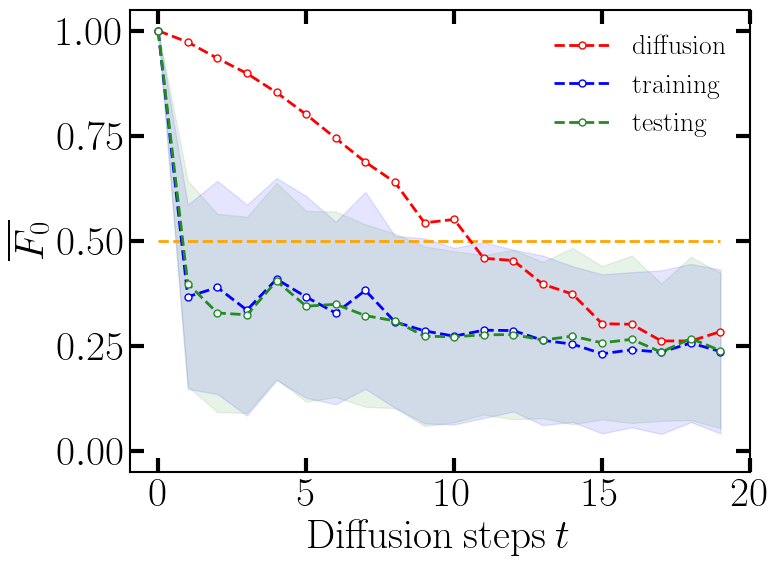

In [146]:
def compute_fidelity(Xout):
    '''
    rewriting the function to give _ALL_ of the fidelty computations before averaging over the batch (for the plot)
    '''
    arr = np.zeros((T,Ndata))
    for i in range(T):
        arr[i] = np.array([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) 
    return arr
states_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
states_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]
states_diff = Xout

F0_train =compute_fidelity(states_train)
F0_test = compute_fidelity(states_test)
F0_diff = compute_fidelity(states_diff)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(T), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T), 0.5*np.ones(T), '--', lw=2, c='orange')

ax.plot(range(T), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
plt.savefig('multimodal_FidelityTest_.pdf',bbox_inches='tight')

plt.show()

plt.close()

### Visulize the performance in MMD distance

In [142]:
# calculate MMD
X = torch.from_numpy(np.array(states_diff,dtype=complex))
X_train = torch.from_numpy(np.array(states_train,dtype=complex))
X_test = torch.from_numpy(np.array(states_test,dtype=complex))
X0 = torch.from_numpy(MultiModeData(n=1,N_train=int(Ndata/2),scale=0.05,seed=None))

mmds = np.zeros((3, T))
for t in range(T):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])


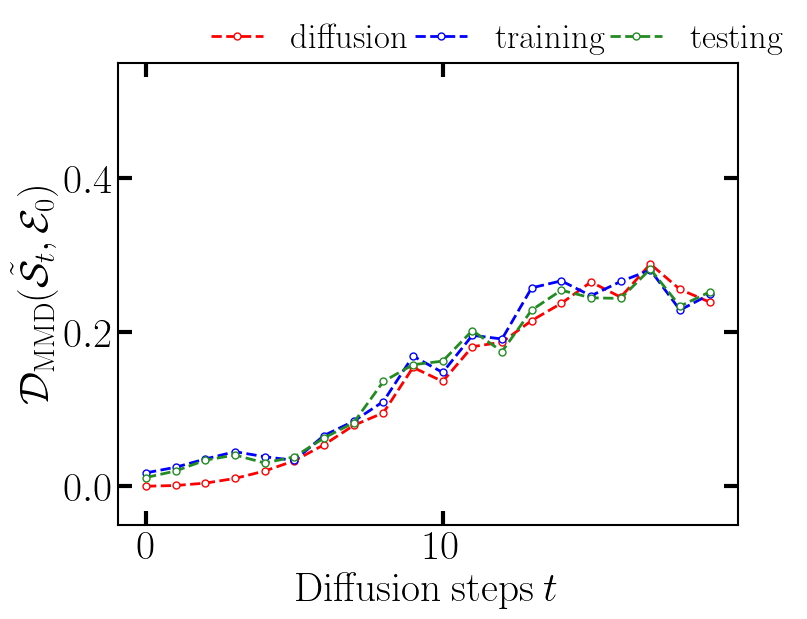

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
plt.savefig('multimodal_MMD_.pdf',bbox_inches='tight')


### Plot the training history

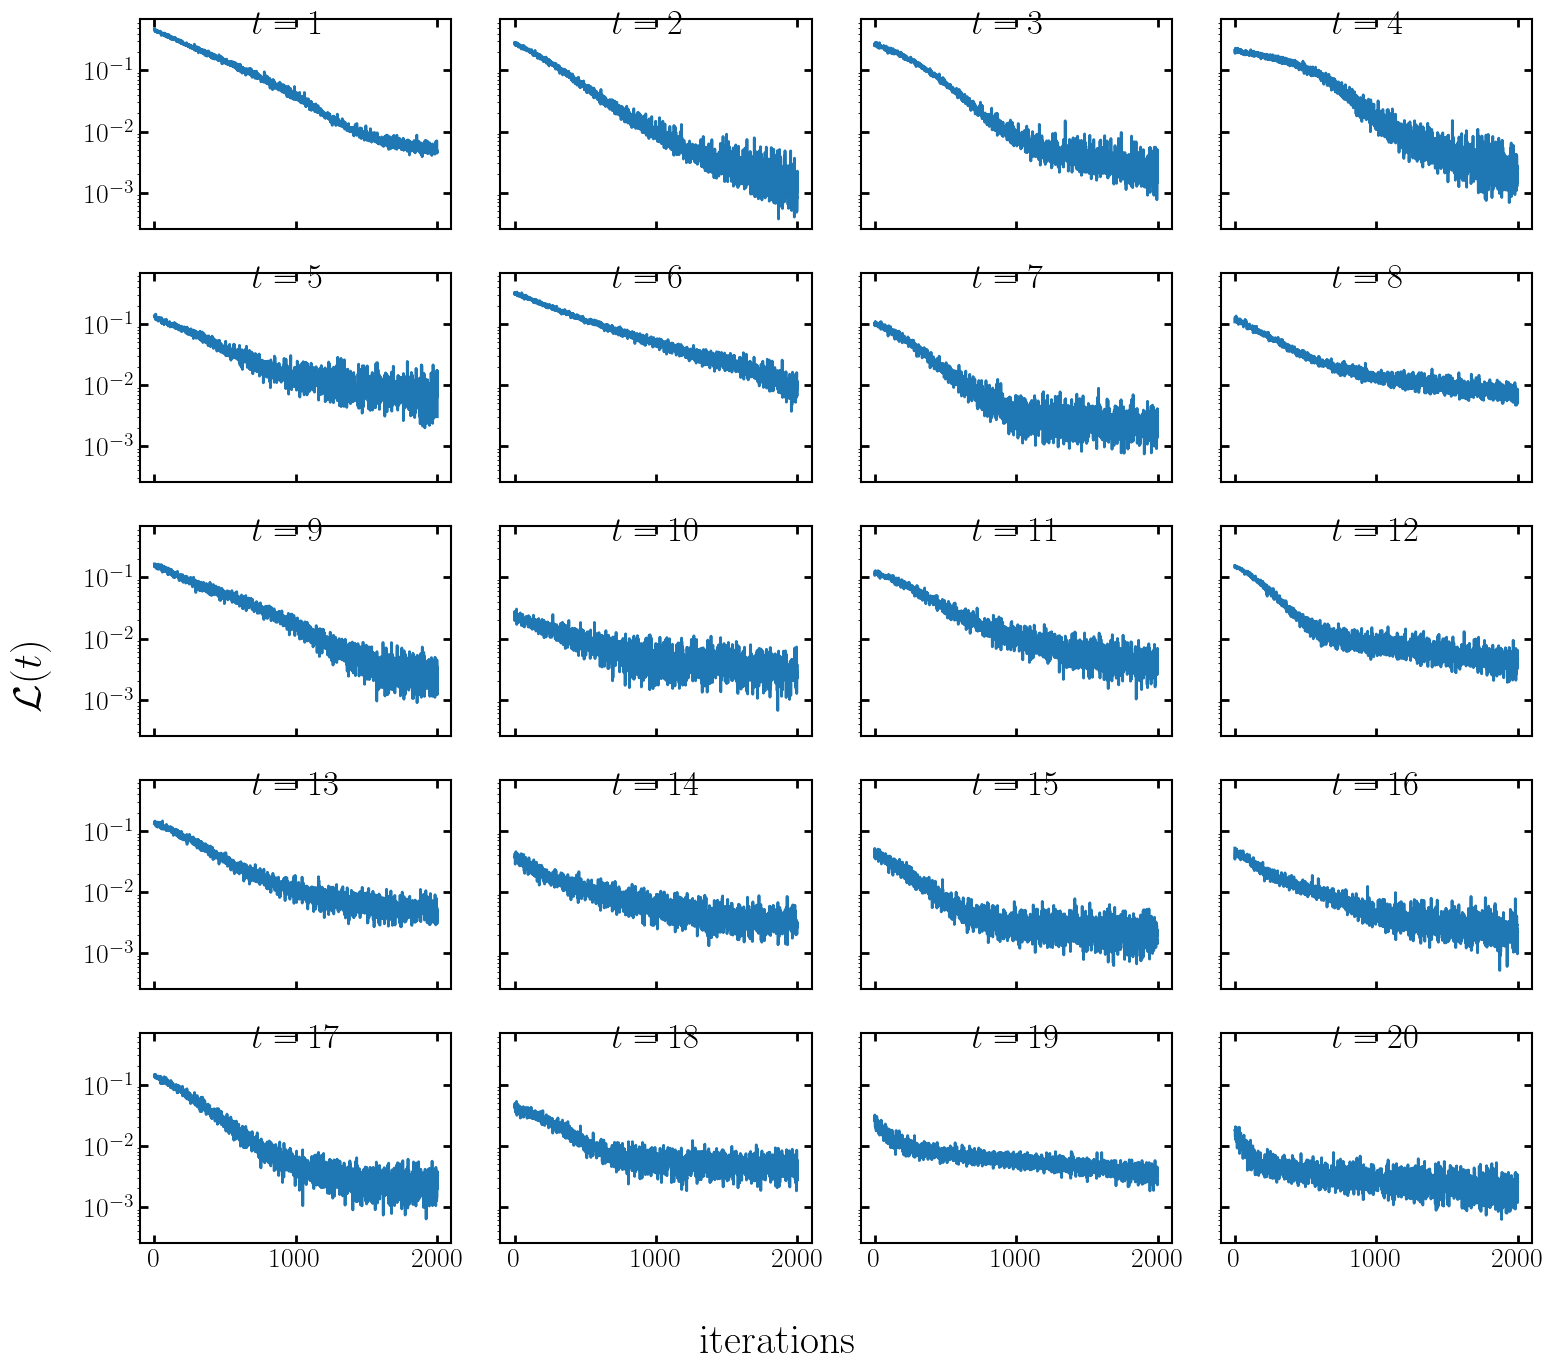

In [47]:
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss_tot[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.show()
plt.savefig('multimodal_trainingcurves_.pdf',bbox_inches='tight')
plt.close()


In [86]:
def project_ancilla(X_train):
    '''
    project the additional ancilla qubit into the possible states,
    and get the post measurement results and combine them into two datasets
    '''
    X_train_0 = []
    X_train_1 = []

    P0 = np.kron(np.identity(2),[[1,0],[0,0]]) #measurement operator
    P1 = np.kron(np.identity(2),[[0,0],[0,1]])
    
    for jj in range(T+1):
        x_train_0 = []
        x_train_1 = []
        for ii in range(Ndata):
            state = X_train[jj,ii,:]
            p0 = np.conjugate(np.transpose(state)) @ P0 @ state  # prob of measuring zero
            p1 = 1 - p0 #prob of measuring 1
            u = np.random.choice([0,1], p=[p0,p1]) #sample a measurement
            if u:
                state_red = state[2:]
                state_red = state_red / np.linalg.norm(state_red)
                x_train_1.append(state_red)
            else:
                state_red = state[:2]
                state_red = state_red / np.linalg.norm(state_red)
                x_train_0.append(state_red)
        X_train_0.append(x_train_0)
        X_train_1.append(x_train_1)
    return (X_train_0), (X_train_1)

/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  u = np.random.choice([0,1], p=[p0,p1])


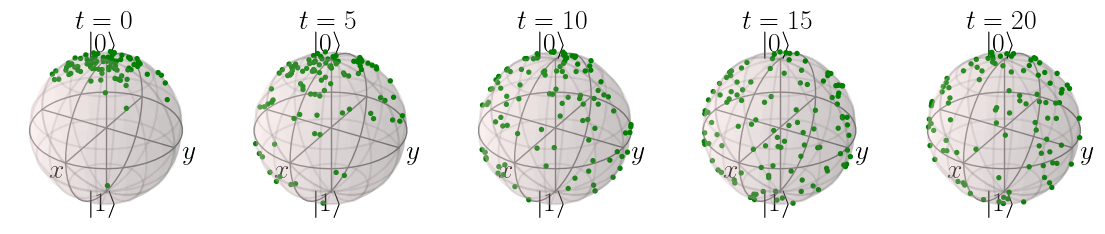

In [138]:
X_train = np.array(states_train,dtype=complex)
X_train_0, X_train_1 = project_ancilla(X_train)
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
# diff_states = X_train_0[:,indices]
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(np.array(X_train_0[i]))
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['g']*(len(X_train_0[i]))
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1

plt.savefig('multimodal_bloch_curves_ZERO.pdf',bbox_inches='tight')


/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_4971/428416102.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  u = np.random.choice([0,1], p=[p0,p1])


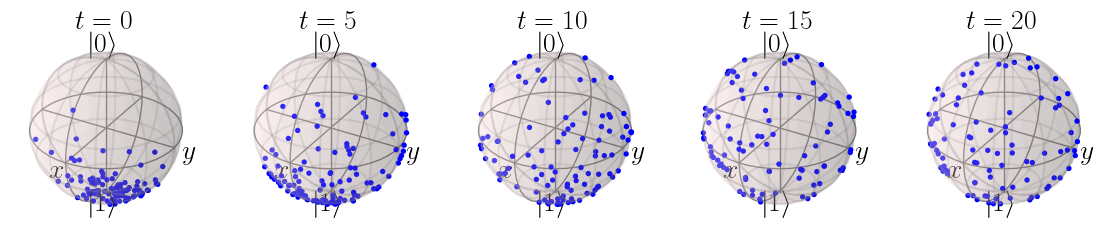

In [139]:
X_train = np.array(states_train,dtype=complex)
X_train_0, X_train_1 = project_ancilla(X_train)
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
# diff_states = X_train_0[:,indices]
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(np.array(X_train_1[i]))
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['b']*(len(X_train_1[i]))
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1

plt.savefig('multimodal_bloch_curves_ONE.pdf',bbox_inches='tight')
